In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

from IPython.display import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.manifold import TSNE

import seaborn as sns
import time

In [3]:
data1 = pd.read_csv('dataset/data1/WA_Fn-UseC_-HR-Employee-Attrition.csv')
data2 = pd.read_csv('dataset/data2/MFG10YearTerminationData.csv')
data3 = pd.read_csv('dataset/data3/turnover.csv',encoding='latin1')

In [4]:
data1.Attrition.value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [5]:
data2.STATUS.value_counts()

ACTIVE        48168
TERMINATED     1485
Name: STATUS, dtype: int64

# Definition du probleme
dans nos differentes bases de donnees, on constate une carence de donne de la classe 2 (ceux qui ont mis un terme a leurs job)
notre petite idee est de creer un model de type GANs capable de fabriquer avec la plus haute precision les users qui n'ont pas quittés leurs jobs

## mais avant il nous faut encoder la donnee categoriel en donnee numerique valide

In [6]:
# define variable utils

latent_dim    = 128

scale         = 0.01
epochs        = 7
batch_size    = 64


In [7]:
data2.shape

(49653, 18)

In [8]:
train, test = np.split(data2.sample(frac=1, random_state=48), [int(.8*len(data2))])

In [9]:
train.shape, test.shape


((39722, 18), (9931, 18))

In [10]:
train

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
39382,6690,12/31/2010 0:00,5/2/1982,4/4/2007,1/1/1900,28,3,Vancouver,Customer Service,Cashier,43,M,Male,Not Applicable,Not Applicable,2010,ACTIVE,STORES
12622,3467,12/31/2012 0:00,5/26/1960,9/3/1995,1/1/1900,52,17,Richmond,Meats,Meat Cutter,29,F,Female,Not Applicable,Not Applicable,2012,ACTIVE,STORES
40038,6771,12/31/2014 0:00,12/27/1982,8/9/2007,1/1/1900,32,7,Nanaimo,Processed Foods,Shelf Stocker,18,F,Female,Not Applicable,Not Applicable,2014,ACTIVE,STORES
15345,3869,12/31/2008 0:00,8/29/1962,11/13/1996,1/1/1900,46,12,Terrace,Produce,Produce Clerk,32,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,STORES
8984,2890,12/31/2006 0:00,7/15/1957,3/1/1994,1/1/1900,49,12,Kelowna,Meats,Meat Cutter,16,F,Female,Not Applicable,Not Applicable,2006,ACTIVE,STORES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3384,1994,12/31/2011 0:00,9/10/1952,8/9/1991,1/1/1900,59,20,Vancouver,Produce,Produce Clerk,41,M,Male,Not Applicable,Not Applicable,2011,ACTIVE,STORES
48704,3611,7/1/2009 0:00,7/29/1944,2/3/1996,7/29/2009,65,13,New Westminster,Meats,Meat Cutter,21,F,Female,Retirement,Voluntary,2009,TERMINATED,STORES
26247,5299,12/31/2012 0:00,2/2/1971,4/27/2001,1/1/1900,41,11,Terrace,Dairy,Dairy Person,32,M,Male,Not Applicable,Not Applicable,2012,ACTIVE,STORES
17069,4112,12/31/2008 0:00,12/26/1963,7/26/1997,1/1/1900,45,11,Squamish,Produce,Produce Clerk,30,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,STORES


In [11]:
train.termtype_desc.value_counts()

Not Applicable    38542
Voluntary          1007
Involuntary         173
Name: termtype_desc, dtype: int64

In [12]:
columns_uses = ['age', 'length_of_service', 'city_name', 'department_name', 'job_title', 'store_name', 'gender_short', 'STATUS', 'BUSINESS_UNIT', 'termreason_desc','termtype_desc']

In [13]:
train = train[columns_uses]
test = test[columns_uses]


In [14]:
train.select_dtypes(['object']).columns

Index(['city_name', 'department_name', 'job_title', 'gender_short', 'STATUS',
       'BUSINESS_UNIT', 'termreason_desc', 'termtype_desc'],
      dtype='object')

<AxesSubplot:ylabel='None'>

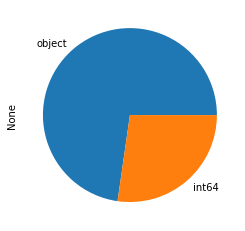

In [15]:
train.dtypes.value_counts().plot.pie()

In [16]:
(train.isna().sum()/train.shape[0]).sort_values(ascending=True)

age                  0.0
length_of_service    0.0
city_name            0.0
department_name      0.0
job_title            0.0
store_name           0.0
gender_short         0.0
STATUS               0.0
BUSINESS_UNIT        0.0
termreason_desc      0.0
termtype_desc        0.0
dtype: float64

In [17]:
le_dictionary= {}
for col in train.select_dtypes(['object']):
  le = preprocessing.LabelEncoder()
  train[col] = le.fit_transform(train[col])
  test[col] = le.transform(test[col])
  #Save a mapping of categorical columns values and its transforamtion - needed
  #later on for mapping purposes
  le_dictionary[col] = dict(zip(le.classes_, le.transform(le.classes_)))

/tmp/ipykernel_5856/2012718178.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = le.fit_transform(train[col])


In [18]:
le_dictionary

{'city_name': {'Abbotsford': 0,
  'Aldergrove': 1,
  'Bella Bella': 2,
  'Blue River': 3,
  'Burnaby': 4,
  'Chilliwack': 5,
  'Cortes Island': 6,
  'Cranbrook': 7,
  'Dawson Creek': 8,
  'Dease Lake': 9,
  'Fort Nelson': 10,
  'Fort St John': 11,
  'Grand Forks': 12,
  'Haney': 13,
  'Kamloops': 14,
  'Kelowna': 15,
  'Langley': 16,
  'Nanaimo': 17,
  'Nelson': 18,
  'New Westminister': 19,
  'New Westminster': 20,
  'North Vancouver': 21,
  'Ocean Falls': 22,
  'Pitt Meadows': 23,
  'Port Coquitlam': 24,
  'Prince George': 25,
  'Princeton': 26,
  'Quesnel': 27,
  'Richmond': 28,
  'Squamish': 29,
  'Surrey': 30,
  'Terrace': 31,
  'Trail': 32,
  'Valemount': 33,
  'Vancouver': 34,
  'Vernon': 35,
  'Victoria': 36,
  'West Vancouver': 37,
  'White Rock': 38,
  'Williams Lake': 39},
 'department_name': {'Accounting': 0,
  'Accounts Payable': 1,
  'Accounts Receiveable': 2,
  'Audit': 3,
  'Bakery': 4,
  'Compensation': 5,
  'Customer Service': 6,
  'Dairy': 7,
  'Employee Records': 8,

In [19]:
train.head()

,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,STATUS,BUSINESS_UNIT,termreason_desc,termtype_desc
39382,28,3,34,6,9,43,1,0,1,1,1
12622,52,17,28,15,34,29,0,0,1,1,1
40038,32,7,17,16,40,18,0,0,1,1,1
15345,46,12,31,17,37,32,1,0,1,1,1
8984,49,12,15,15,34,16,0,0,1,1,1


In [20]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['STATUS'], axis = 1), train['STATUS'], random_state = 48)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29791, 10), (9931, 10), (29791,), (9931,))

In [21]:
params = {'n_estimators' : 500,
          'max_depth': 5,
          'min_child_weight' : 50,
          'gamma': 0.01}
xgb_classifier = XGBClassifier(**params)
xgb_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10)

[0]	validation_0-logloss:0.44212
[1]	validation_0-logloss:0.30377


/home/hacker30/.local/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-logloss:0.21676
[3]	validation_0-logloss:0.15887
[4]	validation_0-logloss:0.11908
[5]	validation_0-logloss:0.09121
[6]	validation_0-logloss:0.07145
[7]	validation_0-logloss:0.05848
[8]	validation_0-logloss:0.04934
[9]	validation_0-logloss:0.04146
[10]	validation_0-logloss:0.03688
[11]	validation_0-logloss:0.03370
[12]	validation_0-logloss:0.03021
[13]	validation_0-logloss:0.02880
[14]	validation_0-logloss:0.02793
[15]	validation_0-logloss:0.02732
[16]	validation_0-logloss:0.02676
[17]	validation_0-logloss:0.02556
[18]	validation_0-logloss:0.02546
[19]	validation_0-logloss:0.02536
[20]	validation_0-logloss:0.02535
[21]	validation_0-logloss:0.02520
[22]	validation_0-logloss:0.02514
[23]	validation_0-logloss:0.02509
[24]	validation_0-logloss:0.02509
[25]	validation_0-logloss:0.02495
[26]	validation_0-logloss:0.02493
[27]	validation_0-logloss:0.02490
[28]	validation_0-logloss:0.02491
[29]	validation_0-logloss:0.02483
[30]	validation_0-logloss:0.02484
[31]	validation_0-logl

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.01, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=50,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [22]:
xgb_classifier.predict_proba(test.drop(['STATUS'], axis = 1))[:,1]

array([0.00428086, 0.00511564, 0.0028509 , ..., 0.00563833, 0.00144616,
       0.0355402 ], dtype=float32)

In [23]:
roc_auc_score(test['STATUS'], xgb_classifier.predict_proba(test.drop(['STATUS'], axis = 1))[:,1])


0.993886264318291

# cATEGORICAL EMBEDDING

In [24]:
train.columns

Index(['age', 'length_of_service', 'city_name', 'department_name', 'job_title',
       'store_name', 'gender_short', 'STATUS', 'BUSINESS_UNIT',
       'termreason_desc', 'termtype_desc'],
      dtype='object')

In [37]:
train.termtype_desc.value_counts()

1    38542
2     1007
0      173
Name: termtype_desc, dtype: int64

In [26]:
columns_for_labelEncoding=['gender_short', 'STATUS', 'BUSINESS_UNIT']
columns_for_EmbeddingEncoding=['city_name', 'department_name', 'job_title','termtype_desc', 'termreason_desc']

In [27]:
input_train_list = []
input_test_list = []
for c in columns_for_EmbeddingEncoding:
  input_train_list.append(X_train[c].values)
  input_test_list.append(X_test[c].values)

In [28]:
input_train_list

[array([17, 30,  7, ..., 29, 24, 34]),
 array([17,  7, 17, ..., 16, 16,  6]),
 array([37, 14, 37, ..., 36, 36,  9]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1])]

In [38]:
# input models will capture all the input list
input_models=[]
# output embeddings will capture all the output embeddings
output_embeddings=[]
for c in columns_for_EmbeddingEncoding:
  cat_emb_name= c+'_Embedding'
  #Identifying the number of unique values in the category
  no_of_unique_cat  =int( X_train[c].nunique())
  # Defining the output embedding size - currently taken it to be 10 for
  # simplicity, Jeremy Howard Fast AI course gives empirical formula for this to
  # be int(min(np.ceil(no_of_unique_cat/2, 50))) i.e choosing the minimum of
  # 50 or half the number of categories in the column
  embedding_size = int(min(np.ceil(no_of_unique_cat/2), 30))
  input_model = layers.Input(shape=(1,),name = c+'_Input')
  output_model = layers.Embedding(no_of_unique_cat, embedding_size,name=cat_emb_name)(input_model)
  output_model = layers.Reshape(target_shape=(embedding_size,))(output_model)

  input_models.append(input_model)
  output_embeddings.append(output_model)

output = layers.Concatenate()(output_embeddings)
output = layers.Dense(512, kernel_initializer="uniform")(output)
output = layers.Activation('relu')(output)
output= layers.Dropout(0.4)(output)
output = layers.Dense(256, kernel_initializer="uniform")(output)
output = layers.Activation('relu')(output)
output= layers.Dropout(0.3)(output)
output = layers.Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics=['accuracy'])

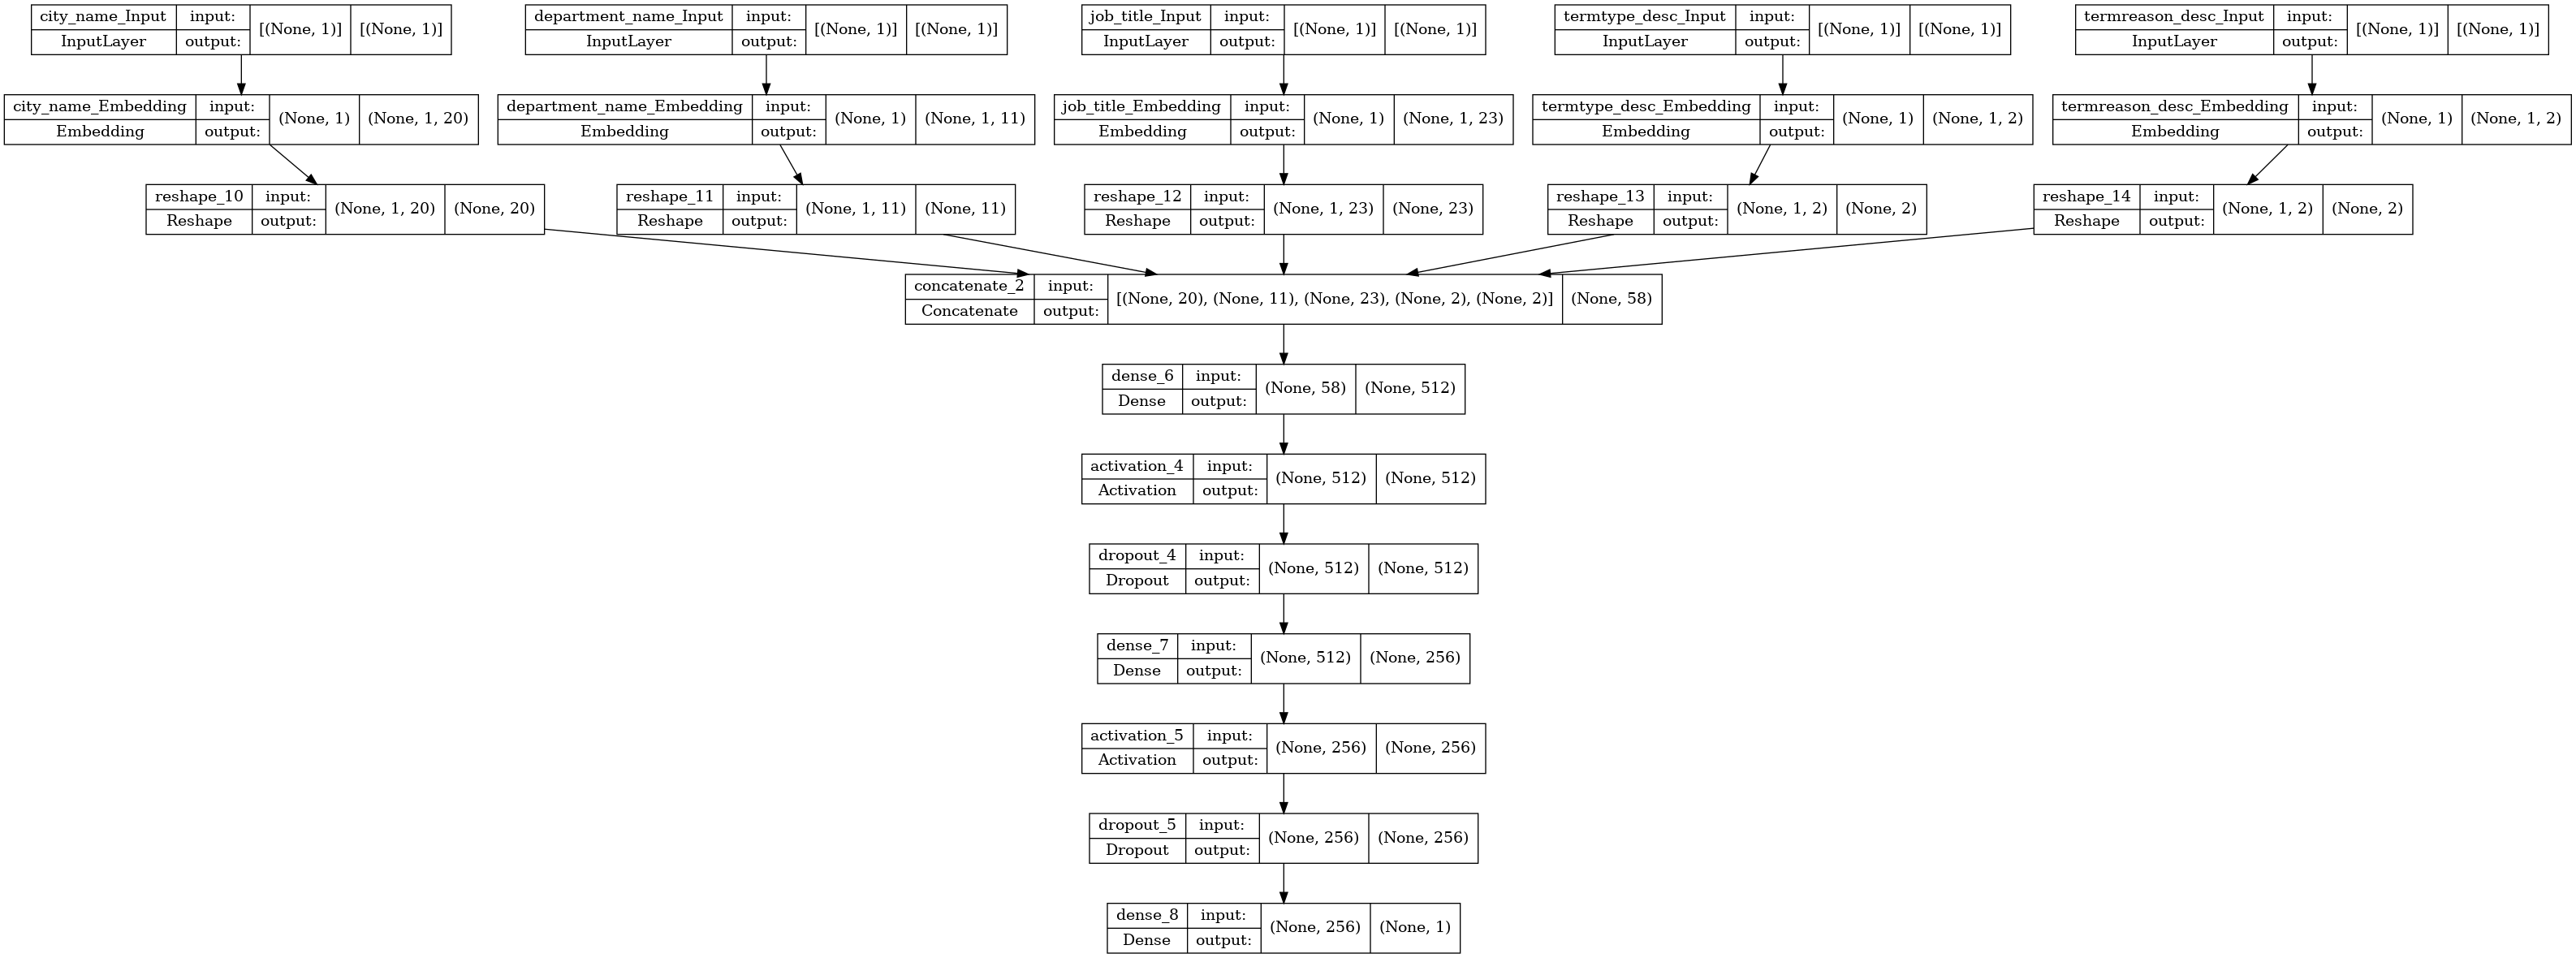

In [39]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [40]:
history  =  model.fit(input_train_list, y_train, validation_data=(input_test_list, y_test) , epochs =  10 , batch_size = 32, verbose= 2)


Epoch 1/10
931/931 - 4s - loss: 0.0357 - accuracy: 0.9915 - val_loss: 0.0183 - val_accuracy: 1.0000 - 4s/epoch - 4ms/step
Epoch 2/10
931/931 - 2s - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 3/10
931/931 - 2s - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 4/10
931/931 - 2s - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 5/10
931/931 - 2s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000 - 2s/epoch - 3ms/step
Epoch 6/10
931/931 - 2s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000 - 2s/epoch - 3ms/step
Epoch 7/10
931/931 - 3s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000 - 3s/epoch - 3ms/step
Epoch 8/10
931/931 - 2s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000 - 2s/epoch - 3ms/step
Epoch 9/10
931/931 - 2s 

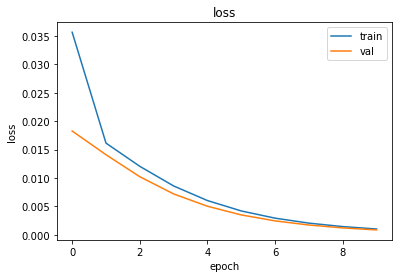

In [41]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [42]:
model.get_layer('city_name_Embedding').get_weights()[0]

array([[ 6.95044771e-02, -1.77610351e-03, -1.32481540e-02,
         8.36671144e-02, -3.43320891e-03,  1.28549654e-02,
        -3.73299345e-02, -5.71176074e-02, -2.36787684e-02,
        -7.92233348e-02,  7.91613653e-04, -2.88776844e-03,
        -3.98229174e-02, -1.34063233e-02,  2.68508084e-02,
        -1.12948371e-02, -4.51626219e-02, -3.93594522e-03,
         1.95386354e-03,  1.44385630e-02],
       [ 6.30317777e-02,  4.96977009e-02,  6.39567301e-02,
         8.38490054e-02, -6.60262257e-02,  5.32421060e-02,
        -4.97733206e-02, -3.18366103e-02,  2.31929328e-02,
        -2.21589468e-02, -8.68485216e-03,  3.99785452e-02,
         2.29892451e-02, -2.19328646e-02,  5.09883463e-02,
         3.66241969e-02, -6.97971806e-02,  7.29391277e-02,
        -6.77392259e-02, -1.69020183e-02],
       [ 1.10341702e-02,  4.24343534e-02, -1.15915593e-02,
        -4.34745997e-02,  5.79181910e-02,  1.54993786e-02,
        -3.24262790e-02,  5.34223616e-02, -2.14389749e-02,
         3.37361172e-02,  1.9

In [43]:
le_dictionary['city_name'].items()

dict_items([('Abbotsford', 0), ('Aldergrove', 1), ('Bella Bella', 2), ('Blue River', 3), ('Burnaby', 4), ('Chilliwack', 5), ('Cortes Island', 6), ('Cranbrook', 7), ('Dawson Creek', 8), ('Dease Lake', 9), ('Fort Nelson', 10), ('Fort St John', 11), ('Grand Forks', 12), ('Haney', 13), ('Kamloops', 14), ('Kelowna', 15), ('Langley', 16), ('Nanaimo', 17), ('Nelson', 18), ('New Westminister', 19), ('New Westminster', 20), ('North Vancouver', 21), ('Ocean Falls', 22), ('Pitt Meadows', 23), ('Port Coquitlam', 24), ('Prince George', 25), ('Princeton', 26), ('Quesnel', 27), ('Richmond', 28), ('Squamish', 29), ('Surrey', 30), ('Terrace', 31), ('Trail', 32), ('Valemount', 33), ('Vancouver', 34), ('Vernon', 35), ('Victoria', 36), ('West Vancouver', 37), ('White Rock', 38), ('Williams Lake', 39)])

In [44]:
# mapping
city_name_embeddings = {idx:model.get_layer('city_name_Embedding').get_weights()[0][idx] for w, idx in le_dictionary['city_name'].items()}


In [45]:
city_name_embeddings

{0: array([ 0.06950448, -0.0017761 , -0.01324815,  0.08366711, -0.00343321,
         0.01285497, -0.03732993, -0.05711761, -0.02367877, -0.07922333,
         0.00079161, -0.00288777, -0.03982292, -0.01340632,  0.02685081,
        -0.01129484, -0.04516262, -0.00393595,  0.00195386,  0.01443856],
       dtype=float32),
 1: array([ 0.06303178,  0.0496977 ,  0.06395673,  0.08384901, -0.06602623,
         0.05324211, -0.04977332, -0.03183661,  0.02319293, -0.02215895,
        -0.00868485,  0.03997855,  0.02298925, -0.02193286,  0.05098835,
         0.0366242 , -0.06979718,  0.07293913, -0.06773923, -0.01690202],
       dtype=float32),
 2: array([ 0.01103417,  0.04243435, -0.01159156, -0.0434746 ,  0.05791819,
         0.01549938, -0.03242628,  0.05342236, -0.02143897,  0.03373612,
         0.01931364,  0.04330657, -0.00143057,  0.01999628,  0.00664198,
         0.01368396, -0.01858105, -0.0422985 ,  0.02369124, -0.04588168],
       dtype=float32),
 3: array([ 0.05971754,  0.05837204, -0.019

In [46]:
city_name_embeddings_df = pd.DataFrame(city_name_embeddings)

In [47]:
city_name_embeddings_df= city_name_embeddings_df.T.reset_index()

In [48]:
city_name_embeddings_df

,index,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,0.069504,-0.001776,-0.013248,0.083667,-0.003433,0.012855,-0.037330,-0.057118,-0.023679,...,0.000792,-0.002888,-0.039823,-0.013406,0.026851,-0.011295,-0.045163,-0.003936,0.001954,0.014439
1,1,0.063032,0.049698,0.063957,0.083849,-0.066026,0.053242,-0.049773,-0.031837,0.023193,...,-0.008685,0.039979,0.022989,-0.021933,0.050988,0.036624,-0.069797,0.072939,-0.067739,-0.016902
2,2,0.011034,0.042434,-0.011592,-0.043475,0.057918,0.015499,-0.032426,0.053422,-0.021439,...,0.019314,0.043307,-0.001431,0.019996,0.006642,0.013684,-0.018581,-0.042298,0.023691,-0.045882
3,3,0.059718,0.058372,-0.019433,0.034965,0.028921,0.053796,-0.041431,0.009521,0.033429,...,0.023907,-0.028040,-0.028426,-0.032074,-0.021860,0.023880,-0.048676,-0.018466,-0.014445,-0.011475
4,4,0.051704,0.040056,0.052329,0.038205,0.004415,0.037659,-0.055026,-0.027639,-0.056195,...,-0.005990,0.047315,0.042472,0.034867,0.018836,-0.030833,0.000931,0.040205,-0.052344,-0.023018
5,5,0.034900,0.039853,-0.043756,-0.040601,-0.009582,-0.051363,-0.041900,0.025646,-0.046957,...,0.024238,-0.028294,0.065943,0.035487,-0.026578,-0.019710,-0.022802,-0.018730,0.002173,0.011430
6,6,0.003550,-0.010718,0.021709,-0.036936,-0.033943,0.032315,-0.011731,-0.019181,-0.020870,...,0.026455,0.025938,0.026114,0.041546,-0.024242,0.001226,0.020690,-0.009260,0.019867,0.021223
7,7,0.020328,0.048580,0.003580,0.075847,-0.072255,-0.002547,0.004176,-0.057076,-0.061230,...,0.025599,0.067632,0.032049,0.005989,0.061302,0.013446,-0.045891,0.067875,-0.009703,-0.030245
8,8,-0.037648,-0.015454,0.007038,-0.018985,-0.024432,0.039478,0.029022,0.016137,-0.006472,...,-0.030094,-0.048150,-0.000253,0.026258,-0.015504,0.008135,0.019598,-0.028230,-0.014378,0.006586
9,9,-0.006316,-0.020509,-0.007655,0.030722,-0.041601,0.034556,0.000722,0.007689,-0.031577,...,-0.015916,0.044893,-0.054081,0.000206,-0.003846,-0.034378,-0.043809,0.005246,0.036074,-0.003256


# Merging the embedding into structured data for training data

In [49]:
train = pd.concat([X_train,y_train], axis= 1)
test = pd.concat([X_test, y_test], axis=1)

In [50]:
train = pd.merge(train, city_name_embeddings_df, how='inner', left_on='city_name', right_on='index')

In [51]:
train

,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,BUSINESS_UNIT,termreason_desc,termtype_desc,...,10,11,12,13,14,15,16,17,18,19
0,56,20,17,17,37,18,1,1,1,1,...,0.017425,-0.011713,0.051607,-0.016271,0.065915,0.004870,-0.033628,0.065595,-0.034043,0.037673
1,48,16,17,4,4,18,1,1,1,1,...,0.017425,-0.011713,0.051607,-0.016271,0.065915,0.004870,-0.033628,0.065595,-0.034043,0.037673
2,57,18,17,15,34,18,0,1,1,1,...,0.017425,-0.011713,0.051607,-0.016271,0.065915,0.004870,-0.033628,0.065595,-0.034043,0.037673
3,41,8,17,4,4,18,1,1,1,1,...,0.017425,-0.011713,0.051607,-0.016271,0.065915,0.004870,-0.033628,0.065595,-0.034043,0.037673
4,42,11,17,4,4,18,1,1,1,1,...,0.017425,-0.011713,0.051607,-0.016271,0.065915,0.004870,-0.033628,0.065595,-0.034043,0.037673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29786,42,12,9,7,14,10,1,1,1,1,...,-0.015916,0.044893,-0.054081,0.000206,-0.003846,-0.034378,-0.043809,0.005246,0.036074,-0.003256
29787,41,10,3,7,14,4,0,1,1,1,...,0.023907,-0.028040,-0.028426,-0.032074,-0.021860,0.023880,-0.048676,-0.018466,-0.014445,-0.011475
29788,36,5,3,7,14,4,0,1,1,1,...,0.023907,-0.028040,-0.028426,-0.032074,-0.021860,0.023880,-0.048676,-0.018466,-0.014445,-0.011475
29789,43,12,3,7,14,4,0,1,1,1,...,0.023907,-0.028040,-0.028426,-0.032074,-0.021860,0.023880,-0.048676,-0.018466,-0.014445,-0.011475


In [17]:

train,test,=train_test_split(data,test_size=0.3,random_state=48)

In [18]:
test.loc[:, 'target'] = -1

In [19]:
df = pd.concat([train,test]).reset_index(drop=True)

In [20]:
df.shape, train.shape, test.shape

((49653, 10), (34757, 9), (14896, 10))

In [21]:
for feat in columns_categorical:
    lb = preprocessing.LabelEncoder()
    df.loc[:, feat] = lb.fit_transform(df[feat].astype(str).fillna("-1").values)

In [22]:
df.fillna("")

,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,STATUS,BUSINESS_UNIT,target
0,44,13,1,4,4,2,1,0,1,
1,28,4,17,16,40,18,1,0,1,
2,37,7,20,4,4,21,0,0,1,
3,65,24,34,18,39,35,0,1,0,
4,28,2,34,7,14,43,0,0,1,
...,...,...,...,...,...,...,...,...,...,...
49648,61,23,4,15,34,5,1,0,1,-1.0
49649,52,16,11,15,34,12,1,0,1,-1.0
49650,44,12,32,4,4,33,1,0,1,-1.0
49651,26,3,36,7,14,46,1,0,1,-1.0


In [23]:
train = df[df.target != -1].reset_index(drop=True)
test = df[df.target == -1].reset_index(drop=True)

In [24]:
train

,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,STATUS,BUSINESS_UNIT,target
0,44,13,1,4,4,2,1,0,1,NaN
1,28,4,17,16,40,18,1,0,1,NaN
2,37,7,20,4,4,21,0,0,1,NaN
3,65,24,34,18,39,35,0,1,0,NaN
4,28,2,34,7,14,43,0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...
34752,27,4,17,6,9,18,1,0,1,NaN
34753,34,5,1,4,4,2,1,0,1,NaN
34754,64,12,30,15,34,31,0,0,1,NaN
34755,57,18,14,15,34,15,1,0,1,NaN


In [25]:
train=train.fillna(0)

In [26]:
def get_model(df, categorical_columns):
    inputs = []
    outputs = []
    for c in categorical_columns:
        num_unique_vals = int(df[c].nunique())
        embed_dim = int(min(np.ceil(num_unique_vals/2), 30))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_vals+1, embed_dim, name=c)(inp)
        # apply dropout here
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
    x = layers.Concatenate()(outputs)
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    y = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=y)
    return model

In [27]:
get_model(train,columns_for_EmbeddingEncoding).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 city_name (Embedding)          (None, 1, 20)        820         ['input_1[0][0]']                
                                                                                              

In [28]:
model= get_model(train, columns_for_EmbeddingEncoding)


In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
history = model.fit([train.loc[:, f].values for f in columns_for_EmbeddingEncoding], train.target.values)

In [31]:
train

,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,STATUS,BUSINESS_UNIT,target
0,44,13,1,4,4,2,1,0,1,0.0
1,28,4,17,16,40,18,1,0,1,0.0
2,37,7,20,4,4,21,0,0,1,0.0
3,65,24,34,18,39,35,0,1,0,0.0
4,28,2,34,7,14,43,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...
34752,27,4,17,6,9,18,1,0,1,0.0
34753,34,5,1,4,4,2,1,0,1,0.0
34754,64,12,30,15,34,31,0,0,1,0.0
34755,57,18,14,15,34,15,1,0,1,0.0


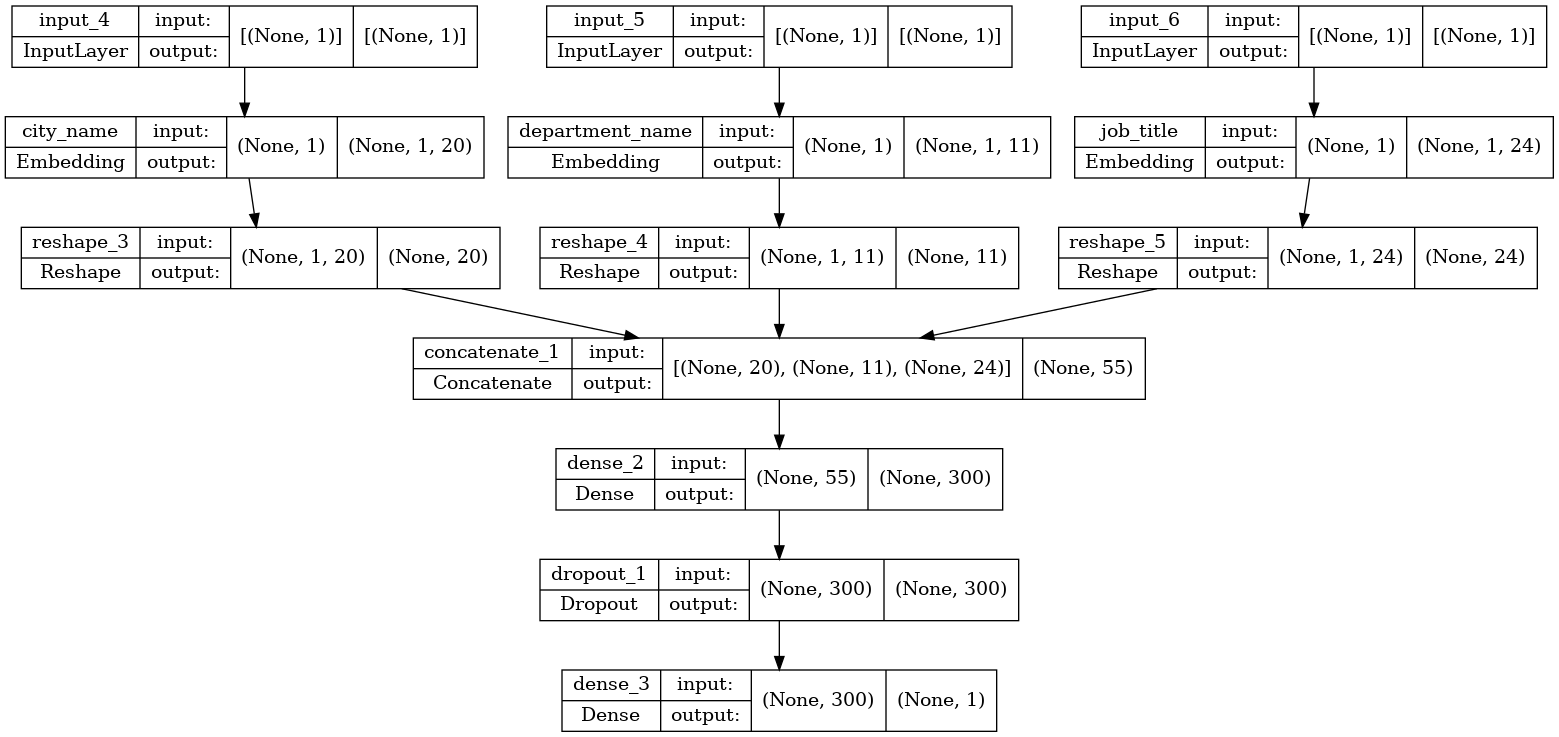

In [37]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()